## Forecast validation for Euclid cosmological probes: Fisher Matrix
Student: Antonia Cisternas \
Teacher: Domenico Sapone

In [465]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import stats, interpolate
import sympy
from scipy.integrate import cumtrapz, solve_ivp, odeint, quadrature
import autograd.numpy as np
from autograd import grad

### Fiducial parameters

We obtain the number density in each redshift bin:
$$
n(z) = \frac{dN(z)}{d\Omega dz} \frac{A_{survey}}{V_s(z)} \Delta z
$$

In [466]:
# f and D for each z_mean:
# f = [0.8790616234808487, 0.9052940279841754, 0.9248305916607235, 0.942646864519483]
# D = [0.6051299241324081, 0.5557769195555776, 0.5132266632166314, 0.46785418122063316]

# Based on table 3 of the page 14:

# We define n using data of number of galaxies per unit area and redshift intervals.
# n = [6.86 * 10**(-4), 5.58 * 10**(-4), 4.21* 10**(-4), 2.61 * 10**(-4)]
V_s = [7.94 * 10**(9), 9.15* 10**(9), 10.05* 10**(9), 16.22* 10**(9)] 
#galazy bias factor
b = [1.4614804, 1.6060949, 1.7464790, 1.8988660]

# Centered position of each bin
z_i = [1., 1.2, 1.4, 1.65]
z_min = [0.9, 1.1, 1.3, 1.5]
z_max = [1.1, 1.3, 1.5, 1.8]

In [467]:
#Fiducial parameters
wb = 0.022445
wm = 0.143648
h = 0.67
c = 300.000

Om_b0 = wb/ (h**2)
H0 = 100 * h
Om_m0 = wm/ (h**2)
ns = 0.96 # Spectral index of the primordial density power spectrum

# np.sqrt(Om_m0 + Om_DE0 + Om_k0) = 1
Om_k0 = 0
Om_DE0 = 1 - Om_m0  

m_nu = 0.06
w_0 = -1
w_a = 0

gamma = 0.55

s8_reference= 0.815583

A_surv = 15000 # Survey area
s_z = 0.0001 # Spectroscopic redshift error
P_s = 0 # Shot noise

# Densidad por unidad de área: dN/(dOmega dz)
dn3= [1815.0, 1701.5, 1410.0, 940.97]

n = np.zeros_like(z_i)
for i in range(len(z_i)):
    n[i] = dn3[i] * A_surv * (z_max[i] - z_min[i])/ V_s[i]

print('n:', n)


n: [0.00068577 0.00055787 0.0004209  0.00026106]


In [468]:
# For a flat space:
def E(z):
    return np.sqrt(Om_m0*((1+z)**(3)) + (1- Om_m0))

def H_ref(z):
    return H0 * E(z)

def r(z):
    z_values = np.linspace(0, z, 1000)
    a = 1 / E(z_values)
    integral = cumtrapz(a, z_values, initial=0)  
    return (c / H0) * integral[-1]

def D_A_ref(z):
    return (1+z)**(-1) * r(z)


### Obtaining the data and interpolation 
Archives "Pk-fiducial-z_0_.dat" and "Pknw-fiducial-z_0_.dat" \
Columns: $k$ , $Pk/ s_8^2$ ,  $s_8$

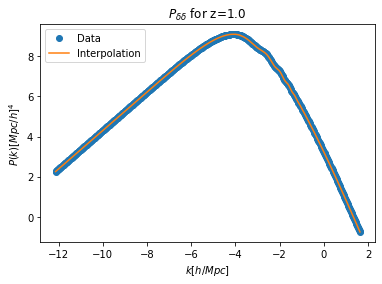

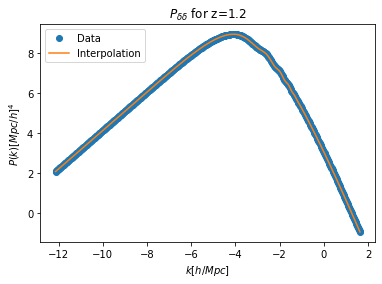

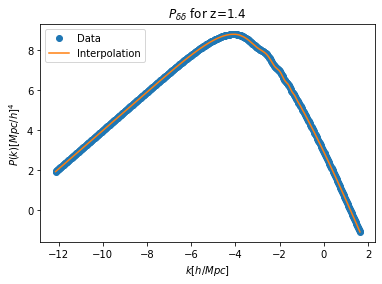

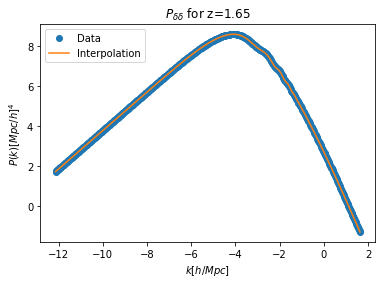

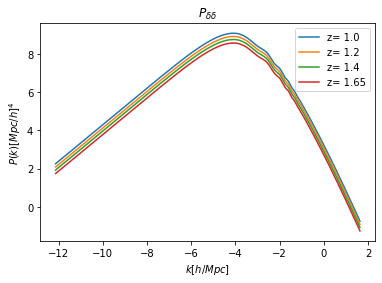

In [469]:
Pk_00 = np.loadtxt("Pk-fiducial\Pk-fiducial-z_00.dat")
Pk_01 = np.loadtxt("Pk-fiducial\Pk-fiducial-z_01.dat")
Pk_02 = np.loadtxt("Pk-fiducial\Pk-fiducial-z_02.dat")
Pk_03 = np.loadtxt("Pk-fiducial\Pk-fiducial-z_03.dat")

Pk_ = [Pk_00,Pk_01, Pk_02, Pk_03 ]

# Cubic spline interpolation
k_= np.empty(4, dtype=object)
y_= np.empty(4, dtype=object)
P_dd_ = np.empty(4, dtype=object)
k_new= np.empty(4, dtype=object)
y_new= np.empty(4, dtype=object)

# i recorre los redshifts
for i in range(0,4):
    k_[i] = np.log(Pk_[i][:,0])
    y_[i] = np.log(Pk_[i][:,1] * (Pk_[i][:,2]**2))
    P_dd_[i] = interpolate.interp1d(k_[i], y_[i], kind='cubic')
    k_new[i] = np.log(np.arange(Pk_[i][:,0][0], Pk_[i][:,0][-1], 0.0001))
    y_new[i] = P_dd_[i](k_new[i])
    plt.title(r"$P_{\delta \delta}$ for z=" + f"{z_i[i]}")
    plt.plot(k_[i], y_[i], 'o', label= "Data")
    plt.plot(k_new[i], y_new[i], '-', label= "Interpolation")
    plt.xlabel(r"$k[h/Mpc]$")
    plt.ylabel(r"$P(k)[Mpc/h]^4$")
    plt.legend()
    plt.show()

plt.title(r"$P_{\delta \delta}$")
plt.plot(k_new[0], y_new[0], '-', label= f"z= {z_i[0]}")
plt.plot(k_new[1], y_new[1], '-', label= f"z= {z_i[1]}")
plt.plot(k_new[2], y_new[2], '-', label= f"z= {z_i[2]}")
plt.plot(k_new[3], y_new[3], '-', label= f"z= {z_i[3]}")
plt.xlabel(r"$k[h/Mpc]$")
plt.ylabel(r"$P(k)[Mpc/h]^4$")
plt.legend()
plt.show()


def P_dd(k, zi):
    i = z_i.index(zi)
    return P_dd_[i](k)

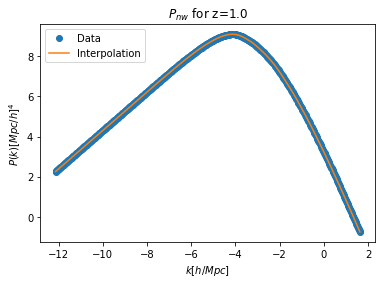

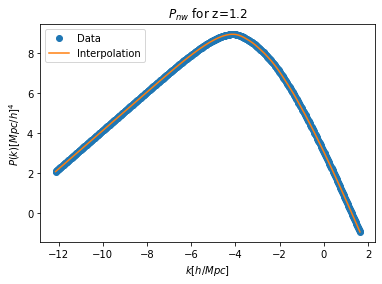

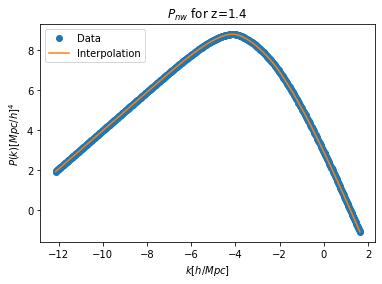

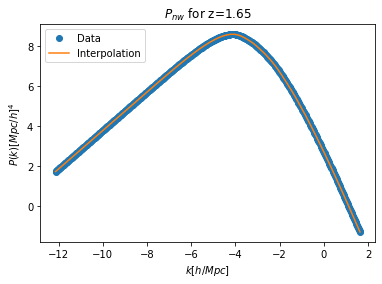

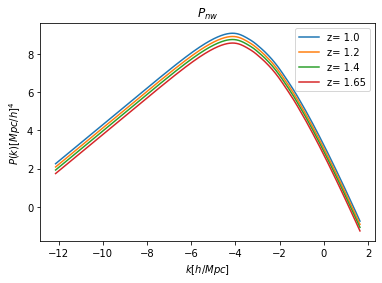

In [470]:
# For Pk_nw (no wiggled power spectrum)
Pk_nw_00 = np.loadtxt("Pk-nw-fiducial\Pk-nw-fiducial-z_00.dat")
Pk_nw_01 = np.loadtxt("Pk-nw-fiducial\Pk-nw-fiducial-z_01.dat")
Pk_nw_02 = np.loadtxt("Pk-nw-fiducial\Pk-nw-fiducial-z_02.dat")
Pk_nw_03 = np.loadtxt("Pk-nw-fiducial\Pk-nw-fiducial-z_03.dat")

Pk_nw = [Pk_nw_00,Pk_nw_01, Pk_nw_02, Pk_nw_03 ]

# Cubic spline interpolation
k_nw= np.empty(4, dtype=object)
y_nw= np.empty(4, dtype=object)
P_nw_ = np.empty(4, dtype=object)
k_nw_new= np.empty(4, dtype=object)
y_nw_new= np.empty(4, dtype=object)
# i recorren los redshifts
for i in range(0,4):
    k_nw[i] = np.log(Pk_nw[i][:,0])
    y_nw[i] = np.log(Pk_nw[i][:,1] * (Pk_nw[i][:,2]**2))
    P_nw_[i] = interpolate.interp1d(k_nw[i], y_nw[i], kind='cubic')
    k_nw_new[i] = np.log(np.arange(Pk_nw[i][:,0][0], Pk_nw[i][:,0][-1], 0.0001))
    y_nw_new[i] = P_nw_[i](k_nw_new[i])
    plt.title(r"$P_{nw}$ for z=" + f"{z_i[i]}")
    plt.plot(k_nw[i], y_nw[i], 'o', label= "Data")
    plt.plot(k_nw_new[i], y_nw_new[i], '-', label= "Interpolation")
    plt.xlabel(r"$k[h/Mpc]$")
    plt.ylabel(r"$P(k)[Mpc/h]^4$")
    plt.legend()
    plt.show()

plt.title(r"$P_{nw}$")
plt.plot(k_nw_new[0], y_nw_new[0], '-', label= f"z= {z_i[0]}")
plt.plot(k_nw_new[1], y_nw_new[1], '-', label= f"z= {z_i[1]}")
plt.plot(k_nw_new[2], y_nw_new[2], '-', label= f"z= {z_i[2]}")
plt.plot(k_nw_new[3], y_nw_new[3], '-', label= f"z= {z_i[3]}")
plt.xlabel(r"$k[h/Mpc]$")
plt.ylabel(r"$P(k)[Mpc/h]^4$")
plt.legend()
plt.show()

def P_nw(k, zi):
    i = z_i.index(zi)
    return P_nw_[i](k)
        

#### Derivatives for P_dd with negative and positive steps

Se define Pk_mn como matriz en la cual sus filas representan un mismo bin y sus columnas representan las derivadas para cada parámetro. 
La derivada para un parámetro corresponde a la posición en la lista param de este parámetro.

In [471]:
param = ['h', 'ns', 'wb', 'wm']

# Derivatives with negative step (mn)
Pk_mn = np.empty((4,4), dtype=object)
columnas = -1
for j in param:
    columnas= columnas + 1
    for i in range(4):
        Pk_mn[i][columnas] = np.loadtxt("Pk-derivative\Pk_"+j+"_mn_eps_1p0E-2\Pk-"+j+"_mn_eps_1p0E-2-z_" + "{:02d}".format(i) + ".dat")

#Ejemplo: Pk_mn[0][1]
#es Pk_mn para el bin 0 y el parámetro ns

# Cubic spline interpolation
k_mn= np.empty((4,4), dtype=object)
y_mn= np.empty((4,4), dtype=object)
P_mn_ = np.empty((4,4), dtype=object)
k_mn_new= np.empty((4,4), dtype=object)
y_mn_new= np.empty((4,4), dtype=object)

# j recorre los parámetros
for j in range(0,4):
    # i recorren los redshifts
    for i in range(0,4):
        k_mn[i][j] = np.log(Pk_mn[i][j][:,0])
        y_mn[i][j] = np.log(Pk_mn[i][j][:,1] * (Pk_mn[i][j][:,2]**2))
        P_mn_[i][j] = interpolate.interp1d(k_mn[i][j], y_mn[i][j], kind='cubic')
        k_mn_new[i][j] = np.log(np.arange(Pk_mn[i][j][:,0][0], Pk_mn[i][j][:,0][-1], 0.0001))
        y_mn_new[i][j] = P_mn_[i][j](k_mn_new[i][j])
        #plt.plot(k_mn[i][j], y_mn[i][j], 'o', k_mn_new[i][j], y_mn_new[i][j], '-')
        #plt.show()

def P_mn(k, zi, j):
    i = z_i.index(zi)
    return P_mn_[i][j](k)

In [472]:
# Derivatives with positive step (pl)
Pk_pl = np.empty((4,4), dtype=object)
columnas = -1
for j in param:
    columnas= columnas + 1
    for i in range(4):
        Pk_pl[i][columnas] = np.loadtxt("Pk-derivative\Pk_"+j+"_pl_eps_1p0E-2\Pk-"+j+"_pl_eps_1p0E-2-z_" + "{:02d}".format(i) + ".dat")

# Cubic spline interpolation
k_pl= np.empty((4,4), dtype=object)
y_pl= np.empty((4,4), dtype=object)
P_pl_ = np.empty((4,4), dtype=object)
k_pl_new= np.empty((4,4), dtype=object)
y_pl_new= np.empty((4,4), dtype=object)

# j recorre los parámetros
for j in range(0,4):
    # i recorren los redshifts
    for i in range(0,4):
        k_pl[i][j] = np.log(Pk_pl[i][j][:,0])
        y_pl[i][j] = np.log(Pk_pl[i][j][:,1] * (Pk_pl[i][j][:,2]**2))
        P_pl_[i][j] = interpolate.interp1d(k_pl[i][j], y_pl[i][j], kind='cubic')
        k_pl_new[i][j] = np.log(np.arange(Pk_pl[i][j][:,0][0], Pk_pl[i][j][:,0][-1], 0.0001))
        y_pl_new[i][j] = P_pl_[i][j](k_pl_new[i][j])
        #plt.plot(k_pl[i][j], y_pl[i][j], 'o', k_pl_new[i][j], y_pl_new[i][j], '-')
        #plt.show()

def P_pl(k, zi, j):
    i = z_i.index(zi)
    return P_pl_[i][j](k)

#### Derivatives for P_nw with negative and positive steps

In [473]:
# Derivatives with negative step (mn)
Pk_nw_mn = np.empty((4,4), dtype=object)
columnas = -1
for j in param:
    columnas= columnas + 1
    for i in range(4):
        Pk_nw_mn[i][columnas] = np.loadtxt("Pk-nw-derivative\Pk_"+ j +"_mn_eps_1p0E-2\Pk-nw-" +j+ "_mn_eps_1p0E-2-z_" + "{:02d}".format(i) + ".dat")

# Cubic spline interpolation
k_nw_mn= np.empty((4,4), dtype=object)
y_nw_mn= np.empty((4,4), dtype=object)
P_nw_mn_ = np.empty((4,4), dtype=object)
k_nw_mn_new= np.empty((4,4), dtype=object)
y_nw_mn_new= np.empty((4,4), dtype=object)

# j recorre los parámetros
for j in range(0,4):
    # i recorren los redshifts
    for i in range(0,4):
        k_nw_mn[i][j] = np.log(Pk_nw_mn[i][j][:,0])
        y_nw_mn[i][j] = np.log(Pk_nw_mn[i][j][:,1] * (Pk_nw_mn[i][j][:,2]**2))
        P_nw_mn_[i][j] = interpolate.interp1d(k_nw_mn[i][j], y_nw_mn[i][j], kind='cubic')
        k_nw_mn_new[i][j] = np.log(np.arange(Pk_nw_mn[i][j][:,0][0], Pk_nw_mn[i][j][:,0][-1], 0.0001))
        y_nw_mn_new[i][j] = P_nw_mn_[i][j](k_nw_mn_new[i][j])
        #plt.plot(k_mn[i][j], y_mn[i][j], 'o', k_mn_new[i][j], y_mn_new[i][j], '-')
        #plt.show()

def P_nw_mn(k, zi, j):
    i = z_i.index(zi)
    return P_nw_mn_[i][j](k)

In [474]:
# Derivatives with positive step (pl)
Pk_nw_pl = np.empty((4,4), dtype=object)
columnas = -1
for j in param:
    columnas= columnas + 1
    for i in range(4):
        Pk_nw_pl[i][columnas] = np.loadtxt("Pk-nw-derivative\Pk_"+ j +"_pl_eps_1p0E-2\Pk-nw-" +j+ "_pl_eps_1p0E-2-z_" + "{:02d}".format(i) + ".dat")

# Cubic spline interpolation
k_nw_pl= np.empty((4,4), dtype=object)
y_nw_pl= np.empty((4,4), dtype=object)
P_nw_pl_ = np.empty((4,4), dtype=object)
k_nw_pl_new= np.empty((4,4), dtype=object)
y_nw_pl_new= np.empty((4,4), dtype=object)

# j recorre los parámetros
for j in range(0,4):
    # i recorren los redshifts
    for i in range(0,4):
        k_nw_pl[i][j] = np.log(Pk_nw_pl[i][j][:,0])
        y_nw_pl[i][j] = np.log(Pk_nw_pl[i][j][:,1] * (Pk_nw_pl[i][j][:,2]**2))
        P_nw_pl_[i][j] = interpolate.interp1d(k_nw_pl[i][j], y_nw_pl[i][j], kind='cubic')
        k_nw_pl_new[i][j] = np.log(np.arange(Pk_nw_pl[i][j][:,0][0], Pk_nw_pl[i][j][:,0][-1], 0.0001))
        y_nw_pl_new[i][j] = P_nw_pl_[i][j](k_nw_pl_new[i][j])
        #plt.plot(k_mn[i][j], y_mn[i][j], 'o', k_mn_new[i][j], y_mn_new[i][j], '-')
        #plt.show()

def P_nw_pl(k, zi, j):
    i = z_i.index(zi)
    return P_nw_pl_[i][j](k)

### Defining functions

Parámetros a encontrar:
$D_A(z_i)$, $H(z_i)$, $f\sigma_8(z_i)$, $b\sigma_8$ , $P_s(z_i)$, $\omega_{b,0}$, $h$, $\omega_{m,0}$, $n_s$, $\sigma_v (z_{mean})$ y $\sigma_p (z_{mean})$


In [475]:
def Om_m(z):
    return Om_m0* (1+z)**3/(E(z)**2)

# For D(z) and f(z)
def derivative(f, a):
    # it is evaluated in z
    dfdz = grad(lambda z: f(z))
    return dfdz(a)

def H_der(z):
    return derivative(H_ref, z)

def fmodel(f, a):
    # xq hay un + en el 2/a - ...?
    dfdz= -f**2/a-(2/a + H_der(a)/H_ref(a))*f + 3*Om_m(1/a-1)/(2*a)
    return dfdz
''' 
Confusión con el cambio de a a 1+z y por qué se hace el fint con 1/1+z
'''
def fint(z):
    f0=1
    aint = np.linspace(0.01,1.0,101)
    fmodelint = odeint(fmodel, f0, aint)
    fmodelintf=np.asarray(fmodelint).squeeze()
    ''' 
    está bien éste?
    '''
    interp_type = 'cubic'
    return interpolate.interp1d(aint,fmodelintf,kind=interp_type)(1/(1+z))

''' 
¿Cuánto es D(0)?
'''
def growth(z):
    return np.exp(-quadrature(lambda zx: (fint(zx) - 1)/(1+zx), 0, z)[0])

def fs8anal(z):
    return s8_reference*fint(z)*growth(z)/(1+z)
def s8anal(z):
    return s8_reference*growth(z)

#print('D', D[0],D[1], D[2], D[2])
D = [growth(z_i[0]), growth(z_i[1]), growth(z_i[2]), growth(z_i[3])]
print('growth', growth(z_i[0]), growth(z_i[1]), growth(z_i[2]), growth(z_i[3]))

#print('f', f[0], f[1], f[2], f[3])
f = [float(fint(z_i[0])), float(fint(z_i[1])), float(fint(z_i[2])), float(fint(z_i[3]))]
print('fint', f)

growth 1.5160624085566599 1.5907385921825703 1.6601540738214384 1.7409113357342358
fint [0.4875512395014176, 0.503028637285818, 0.5148752835775298, 0.5260654822958152]


In [476]:
# s8 es el mismo para cada z
s8 = np.zeros_like(z_i)
bs8 = np.zeros_like(z_i)
fs8 = np.zeros_like(z_i)
for i in range(0, 4):
        s8[i]= Pk_[i][0,2]
        bs8[i] = b[i]* s8[i]
        fs8[i] = f[i]* s8[i]


z_mean 1.35


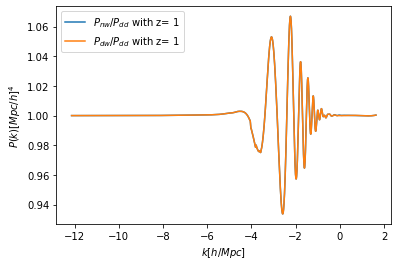

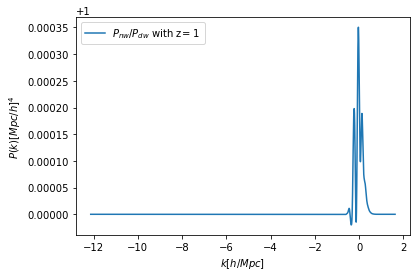

In [477]:
# In practice:
#sv(z) controls the strength of the non-linear damping of the BAO signal in all directions.
def sv_(zi):
  j = z_i.index(zi)
  I = np.trapz(np.exp(P_dd(k_new[j], z_i[j])), np.exp(k_new[j]))
  return np.sqrt((1/(6* (np.pi**2)))* I)
def sp_(zi):
  j = z_i.index(zi)
  I = np.trapz(np.exp(P_dd(k_new[j], z_i[j])), np.exp(k_new[j]))
  return np.sqrt((1/(6* (np.pi**2)))* I)

sv = [sv_(z_i[0]), sv_(z_i[1]), sv_(z_i[2]), sv_(z_i[3])]
#sv = [0.1,0.1,0.1,0.1]
sp = [sp_(z_i[0]), sp_(z_i[1]), sp_(z_i[2]), sp_(z_i[3])]
#####################
z_mean = (z_max[3]-z_min[0])/2 + z_min[0]
print('z_mean', z_mean)
'''
sv(zmean)
'''
#def sv(z):
#  return sv

###################

# Comoving distance error sigma_r = (c/H(z))*(1+z)* sigma_{0,z}
def F_z(k_ref,u_ref,z):
  return np.exp(-((k_ref* u_ref* c *(1+z)* s_z)/H_ref(z))**2)

def qpar(z, H = None):
  H_value = H_ref(z) if H is None else H
  return H_ref(z)/H_value

def qper(z, D_A = None):
  D_A_value = D_A_ref(z) if D_A is None else D_A
  return D_A_value/ D_A_ref(z)


# To convert the known reference k_ref and mu_ref to the unknown, true k and mu
def k(z, k_ref, u_ref, H = None, D_A = None):
  qper1 = qper(z, D_A = D_A)
  qpar1 = qpar(z, H = H)
  return (k_ref /qper1)* (1 + u_ref**2 *((qper1**2/qpar1**2) -1))**(0.5)

def u(z, k_ref, u_ref, H = None, D_A = None):
  qper1 = qper(z, D_A = D_A)
  qpar1 = qpar(z, H = H)
  return u_ref * (qper1/qpar1) * (1 + u_ref**2 *((qper1**2/qpar1**2) -1))**(-0.5)

# Non-linear damping factor of the BAO signal.
def g_u(u, zi, sv1 = None):
  bin = z_i.index(zi)
  sv1_value = sv[bin] if sv1 is None else sv1
  return sv1_value**2 *(1- u**2 + (u**2)*(1+ f[bin])**2)

def P_dw(k, u, z, sv1 = None, paso = None, var = None):
  bin = z_i.index(z)
  sv1_value = sv[bin] if sv1 is None else sv1

  if paso == None:
    return np.exp(P_dd(k, z))* np.exp(-g_u(u ,z , sv1 = sv1_value)*k**2) + np.exp(P_nw(k, z))* (1- np.exp(-g_u(u,z, sv1 = sv1_value)*k**2))
  
  elif paso == 'pl':
    return np.exp(P_pl(k, z, var))* np.exp(-g_u(u,z, sv1 = sv1_value)*k**2) + np.exp(P_nw_pl(k, z, var))* (1- np.exp(-g_u(u,z, sv1 = sv1_value)*k**2))
    
  else:
    return np.exp(P_mn(k, z, var))* np.exp(-g_u(u,z, sv1 = sv1_value)*k**2) + np.exp(P_nw_mn(k, z, var))* (1- np.exp(-g_u(u,z, sv1 = sv1_value)*k**2))

# Probando:
u_prueba = np.linspace(-1,1, 50927)
k1 = k(z_i[0],k_new[0], u_prueba) 
k2 = k(z_i[0],k_nw_new[0], u_prueba) 
u1 = u(z_i[0],k_new[0], u_prueba)

plt.plot(k2, np.exp(P_nw(k2, z_i[0]))/np.exp(P_dd(k1,  z_i[0])),  label = r'$P_{nw}/P_{dd}$ with z= 1')
plt.plot(k_new[0], P_dw(k2, u_prueba, z_i[0])/np.exp(P_dd(k_new[0],  z_i[0])), label = r'$P_{dw}/P_{dd}$ with z= 1')
plt.xlabel(r"$k[h/Mpc]$")
plt.ylabel(r"$P(k)[Mpc/h]^4$")
plt.legend()
plt.show()

plt.plot(k_new[0], np.exp(P_nw(k2, z_i[0]))/P_dw(k2, u_prueba, z_i[0]), label = r'$P_{nw}/P_{dw}$ with z= 1')
plt.xlabel(r"$k[h/Mpc]$")
plt.ylabel(r"$P(k)[Mpc/h]^4$")
plt.legend()
plt.show()

### Defining P_obs and V_eff

In [478]:
# Full non-linear model
def P_obs(k_ref, u_ref, zi, bs81=None, fs81=None, f1= None , sp1=None, s81= None, H= None, D_A = None):
  bin = z_i.index(zi)
  bs8_value = bs8[bin] if bs81 is None else bs81
  fs8_value = fs8[bin] if fs81 is None else fs81
  f_value = f[bin] if f1 is None else f1
  sp_value = sp[bin] if sp1 is None else sp1
  s8_value = s8[bin] if s81 is None else s81
  H_value = None if H is None else H
  D_A_value = None if D_A is None else D_A
  
  k_eval = k(zi, k_ref, u_ref, H = H_value, D_A = D_A_value)
  u_eval = u(zi, k_ref, u_ref, H = H_value, D_A = D_A_value)

  return (1/(qpar(zi, H= H_value)**2 * qper(zi, D_A = D_A_value)))*((bs8_value + (fs8_value* u_eval**2))**2/(1+(f_value*k_eval*u_eval*sp_value)**2)) * (P_dw(k_eval,u_eval,zi)/s8_value**2)* F_z(k_eval,u_eval,zi) + P_s

def V_eff(zi, k_ref, u_ref):
  bin = z_i.index(zi)
  return V_s[bin] * (((n[bin])*P_obs(k_ref, u_ref, zi))/(n[bin]*P_obs(k_ref,u_ref, zi) + 1))**2

### Derivatives

In [479]:
# epsilon varía entre los 0.0001 y 0.01
def derivada_ln_P_obs(k_ref, u_ref, z, a, eps =0.0001):
    #k1= k(z, k_ref, u_ref)
    #u1= u(z, k_ref, u_ref)
    
    bin = z_i.index(z)
    k_eval = k(z, k_ref, u_ref)
    u_eval = u(z, k_ref, u_ref)

    if a == 'Ps':
      derivada = 1/ P_obs(k_ref, u_ref, z)
      
    # if are shape parameters wb , h, wm , ns
    elif a == 'wb' or a== 'h' or a == 'wm' or a == 'ns':
      # str to function
      if a == 'wb':
        a1 = wb
      elif a == 'h':
        a1 = h
      elif a == 'wm':
        a1 = wm
      elif a == 'ns':
        a1 = ns
      
      for j in range(0,4):
        if a == param[j]:
          var = j
          derivada = (np.log(P_dw(k_ref, u_ref, z, paso = 'pl', var = var)/s8[bin]**2)- np.log(P_dw(k_ref, u_ref, z, paso = 'mn', var = var)/s8[bin]**2) )/ (2 * eps* a1)

    # if are non-linear parameters sv y sp
    # three-point stencil derivative of f with respect to x at x0
    elif a == 'sv':
      derivada = (np.log(P_dw(k_ref, u_ref, z, sv1 = sv[bin]*(1+ eps))/ s8[bin]**2)- np.log(P_dw(k_ref, u_ref, z, sv1 = sv[bin]*(1 - eps))/ s8[bin]**2)) / (2 * eps *sv[bin] )

    elif a == 'sp':
      term_pos = (f[bin]*k_ref* u_ref*sp[bin]*(1+ eps))**2
      term_neg = (f[bin]*k_ref* u_ref*sp[bin]*(1- eps))**2
      
      derivada = (np.log(1/ (1+ term_pos))- np.log(1 / (1+ term_neg))) / (2 * eps * sp[bin])
      
    # if parameters are fs8 and bs8
    elif a == 'fs8':
      derivada = (np.log(P_obs(k_ref, u_ref, z, fs81 = fs8[bin]**(1 + eps))) - np.log(P_obs(k_ref, u_ref, z, fs81 = fs8[bin]**(1 - eps)))) / (2* eps * np.log(fs8[bin]))

    elif a == 'bs8':
      derivada = (np.log(P_obs(k_ref, u_ref, z, bs81 = bs8[bin]**(1 + eps))) - np.log(P_obs(k_ref, u_ref, z, bs81 = bs8[bin]**(1 - eps)))) / (2* eps * np.log(bs8[bin]))

    # if parameters are H and D_A, five point stencil
    elif a == 'H':
      derivada = 8* (np.log(P_obs(k_ref, u_ref, z, H= H_ref(z)**(1+ eps)))- np.log(P_obs(k_ref, u_ref, z, H= H_ref(z)**(1- eps))))/(12* eps * np.log(H_ref(z))) - (np.log(P_obs(k_ref, u_ref, z, H= H_ref(z)**(1+ 2*eps)))- np.log(P_obs(k_ref, u_ref, z, H= H_ref(z)**(1 - 2*eps))))/(12* eps * np.log(H_ref(z)))
    elif a == 'D_A':
      derivada = 8* (np.log(P_obs(k_ref, u_ref, z, D_A = D_A_ref(z)**(1+ eps)))- np.log(P_obs(k_ref, u_ref, z, D_A = D_A_ref(z)**(1- eps))))/(12* eps * np.log(D_A_ref(z))) - (np.log(P_obs(k_ref, u_ref, z, D_A = D_A_ref(z)**(1+ 2*eps)))- np.log(P_obs(k_ref, u_ref, z, D_A = D_A_ref(z)**(1 - 2*eps))))/(12* eps * np.log(D_A_ref(z)))

    return derivada



### Double integral

In [480]:
def double_integral(func, u_range, k_range, num_intervals_u, num_intervals_k, zi, a, b):
    # Crea una malla de puntos en el plano de integración
    u_vals = np.linspace(u_range[0], u_range[1], num_intervals_u)
    k_vals = np.linspace(k_range[0], k_range[1], num_intervals_k)

    # Evalúa la función en cada punto de la malla
    z_vals = np.zeros((num_intervals_u, num_intervals_k))
    for j in range(num_intervals_k):
        z_vals[:,j] = func(u_vals, k_vals[j], zi, a, b)

    # Integra a lo largo del eje y (primera integral)
    integral_k = np.trapz(z_vals, x=k_vals, axis=0)
    # Integra a lo largo del eje x (segunda integral)
    integral = np.trapz(integral_k, x=u_vals)
    return integral

def func_to_integrate(u_ref, k_ref, zi, a, b):
  return (k_ref)**2 * derivada_ln_P_obs(k_ref, u_ref, zi, a) * derivada_ln_P_obs(k_ref, u_ref, zi, b)* V_eff(zi, k_ref, u_ref)

# Define los límites de integración y el número de intervalos en cada dimensión
# Pessimistic setting

x_range = [0.001* h, 0.25 * h]
y_range = [-1, 1]
num_intervals_x = 100
num_intervals_y = 100


### Fisher matrix for a bin

In [481]:
shape_param = ['wb', 'h', 'wm', 'ns', 'sp', 'sv']
redshift_param= [ 'D_A', 'H', 'fs8', 'bs8', 'Ps']
parameters = shape_param + redshift_param

# 6 x 6 matrix: shape parameters 
# 5 x 5 matrix: redshift dependant parameters

F_ij_bin = np.empty((len(parameters), len(parameters)))

for i in range(len(parameters)):
    for j in range(len(parameters)):
        if j <= i :
            a = parameters[i]
            b = parameters[j]
            result = (1/(8* np.pi**2))*double_integral(func_to_integrate, x_range, y_range, num_intervals_x, num_intervals_y, z_i[0], a, b)
            F_ij_bin[i][j] = result
            F_ij_bin[j][i] = result

print('F_ij_bin:', F_ij_bin)
# Sacando la matriz de covarianza
C_bin = np.linalg.inv(F_ij_bin)
print('C_bin:', C_bin)

F_ij_bin: [[ 1.73205004e+12 -5.00806196e+10 -6.54326953e+11 -9.46997434e+10
   5.91649282e+06 -9.64844006e+02  1.45689692e+09 -1.07407754e+09
  -3.30630563e+06 -1.07670487e+09 -1.77320784e+06]
 [-5.00806196e+10  1.46568171e+09  1.88704702e+10  2.71631086e+09
  -1.76262870e+05  2.14951790e+01 -4.26147718e+07  3.10775357e+07
   9.56398797e+04  3.11675860e+07  4.80626831e+04]
 [-6.54326953e+11  1.88704702e+10  2.47324964e+11  3.58353433e+10
  -2.22084435e+06  3.82895664e+02 -5.49050777e+08  4.05705329e+08
   1.24894106e+06  4.06659017e+08  6.78598214e+05]
 [-9.46997434e+10  2.71631086e+09  3.58353433e+10  5.20653775e+09
  -3.17029892e+05  6.22219321e+01 -7.89838768e+07  5.86923344e+07
   1.80704603e+05  5.88190999e+07  1.02288883e+05]
 [ 5.91649282e+06 -1.76262870e+05 -2.22084435e+06 -3.17029892e+05
   3.90430435e+01 -1.12662001e-03  5.08085781e+03 -3.65675541e+03
  -2.03235389e+01 -3.68026538e+03 -5.46201610e+00]
 [-9.64844006e+02  2.14951790e+01  3.82895664e+02  6.22219321e+01
  -1.1266

In [482]:
for i in range(len(C_bin)):
    print(f'sigma {parameters[i]}', np.sqrt(C_bin[i,i]))

sigma wb 0.005955360589870396
sigma h 0.04724335663931369
sigma wm 0.029768805085562514
sigma ns 0.08140144292619358
sigma sp 10.333762695117548
sigma sv 261.52760143412934
sigma D_A 2.310244277743513
sigma H 3.2159284229217198
sigma fs8 9.595989198598865
sigma bs8 3.066679000933185
sigma Ps 2.504024037238168


### Total fisher matrix

In [483]:
shape_param = ['wb', 'h', 'wm', 'ns', 'sp', 'sv']
redshift_param= [ 'D_A', 'H', 'fs8', 'bs8', 'Ps']
parameters = shape_param + redshift_param

# 6 x 6 matrix: shape parameters 
# 5 x 5 matrix: redshift dependant parameters
F_ij_shape = np.empty((4, len(shape_param), len(shape_param)))

for l in range(len(z_i)):
    for i in range(len(shape_param)):
        for j in range(len(shape_param)):
            if j <= i :
                a = shape_param[i]
                b = shape_param[j]
                result = (1/(8* np.pi**2))*double_integral(func_to_integrate, x_range, y_range, num_intervals_x, num_intervals_y, z_i[l], a, b)
                F_ij_shape[l][i][j] = result
                F_ij_shape[l][j][i] = result


In [484]:
F_ij_redshift = np.empty((4, len(redshift_param), len(redshift_param)))

for l in range(len(z_i)):
    for i in range(len(redshift_param)):
        for j in range(len(redshift_param)):
            if j <= i :
                a = redshift_param[i]
                b = redshift_param[j]
                result = (1/(8* np.pi**2))*double_integral(func_to_integrate, x_range, y_range, num_intervals_x, num_intervals_y, z_i[l], a, b)
                F_ij_redshift[l][i][j] = result
                F_ij_redshift[l][j][i] = result


In [485]:
# Se define F_ij_mixed como la matriz de 5 x 6 correspondiente a las derivadas mezcladas entre shape parameters y redshift dependant parameters.
F_ij_mixed = np.empty((4, len(redshift_param), len(shape_param)))

for l in range(len(z_i)):
    for i in range(len(redshift_param)):
        for j in range(len(shape_param)):
                a = redshift_param[i]
                b = shape_param[j]
                result = (1/(8* np.pi**2))*double_integral(func_to_integrate, x_range, y_range, num_intervals_x, num_intervals_y, z_i[l], a, b)
                F_ij_mixed[l][i][j] = result

# F_ij_mixed_t es la matriz de 6 x 5 de las mixed derivatives.
F_ij_mixed_t = np.empty((4, len(shape_param), len(redshift_param)))
for i in range(len(z_i)):
    F_ij_mixed_t[i] = np.transpose(F_ij_mixed[i])

In [486]:
F_ij = []
for _ in range(len(z_i)+1):
    fila = [None] * (len(z_i)+1)  # Cada fila tendrá len(z_i) +1 columnas inicializadas en None
    F_ij.append(fila)

# Submatriz a agregar:
# Matriz de 6 x 6 correspondiente a los shape parameters
F_ij_6x6= np.sum(F_ij_shape, axis=0)

# Agregando F_ij_6x6 al elemento [0][0]
if not isinstance(F_ij[0][0], list):
    F_ij[0][0] = []
F_ij[0][0].extend(F_ij_6x6)

# Para cada redshift, se agrega la matriz correspondiente
for l in range(len(z_i)):
    if not isinstance(F_ij[0][l+1], list):
        F_ij[0][l+1] = []
    if not isinstance(F_ij[l+1][0], list):
        F_ij[l+1][0] = []
    if not isinstance(F_ij[l+1][l+1], list):
        F_ij[l+1][l+1] = []

    F_ij[0][l+1].extend(F_ij_mixed_t[l])
    F_ij[l+1][0].extend(F_ij_mixed[l])
    F_ij[l+1][l+1].extend(F_ij_redshift[l])

for filas in range(len(F_ij)):
    for columnas in range(len(F_ij)):
        if F_ij[filas][columnas]== None:
            if not isinstance(F_ij[filas][columnas], list):
                F_ij[filas][columnas] = []

            F_ij[filas][columnas].extend(np.zeros((5,5)))

# for fila in F_ij:
#     print(fila)

# Convertir cada lista a un array
for i, sublist in enumerate(F_ij):
    for j, item in enumerate(sublist):
        if isinstance(item, list):
            F_ij[i][j] = np.array(item)

# Concatenar los arrays en una sola matriz
F_ij = np.block(F_ij)
print('F_ij:', F_ij)

# Sacando la matriz de covarianza
C = np.linalg.inv(F_ij)
print('C:', C)


F_ij: [[ 4.89753901e+12 -1.53798899e+11 -1.82154041e+12 -2.67404894e+11
   1.63825057e+07 -6.27300051e+03  1.45689692e+09 -1.07407754e+09
  -3.30630563e+06 -1.07670487e+09 -1.77320784e+06  1.23880552e+09
  -9.13121693e+08 -2.63956787e+06 -9.14156698e+08 -1.46336122e+06
   8.58082791e+08 -6.32175510e+08 -1.72041486e+06 -6.32090998e+08
  -9.92352203e+05  5.75231160e+08 -4.23465385e+08 -1.08321065e+06
  -4.22771103e+08 -6.66234751e+05]
 [-1.53798899e+11  4.90259755e+09  5.70106822e+10  8.33572858e+09
  -5.27894194e+05  1.80775643e+02 -4.26147718e+07  3.10775357e+07
   9.56398797e+04  3.11675860e+07  4.80626831e+04 -3.92949475e+07
   2.86807652e+07  8.28864745e+04  2.87237002e+07  4.33353473e+04
  -2.88197105e+07  2.10409979e+07  5.72468575e+04  2.10443972e+07
   3.12952141e+04 -2.03164225e+07  1.48325202e+07  3.79315454e+04
   1.48116079e+07  2.22170780e+04]
 [-1.82154041e+12  5.70106822e+10  6.77995545e+11  9.96250670e+10
  -6.05591969e+06  2.39043305e+03 -5.49050777e+08  4.05705329e+08


In [487]:
np.set_printoptions(suppress=True, precision=8)

sigmas = np.zeros(len(C))
for i in range(len(C)):
    sigmas[i] = np.sqrt(C[i, i])
print('wb h wm ns sp sv')
print(sigmas[:6])
print('z lnDa lnH lnfs8 lnbs8 Ps')
z1_concatenado = np.concatenate((np.array([z_i[0]]), sigmas[6:11]))
print(z1_concatenado)
z2_concatenado = np.concatenate((np.array([z_i[1]]), sigmas[11:16]))
print(z2_concatenado)
z3_concatenado = np.concatenate((np.array([z_i[2]]), sigmas[16:21]))
print(z3_concatenado)
z4_concatenado = np.concatenate((np.array([z_i[3]]), sigmas[21:26]))
print(z4_concatenado)

'''
wb h wm ns sp sv
[0.00931 0.03455 0.04288 0.08462 2.21195 0.53985]
z lnDa lnH lnfs8 lnbs8 Ps
[ 1.       0.1246   0.12494  0.11465  0.12122 72.26408]
[ 1.2      0.12471  0.12505  0.11562  0.12145 75.26099]
[ 1.4      0.12486  0.12517  0.11677  0.12162 78.89253]
[ 1.65     0.12508  0.12528  0.11793  0.12173 80.63822]
'''


wb h wm ns sp sv
[ 0.00297615  0.02369089  0.01490606  0.04058823  4.96814001 62.56787596]
z lnDa lnH lnfs8 lnbs8 Ps
[1.         1.14628995 1.58639482 5.06890945 1.55442972 1.69203215]
[1.2        1.14645891 1.77053019 5.84138482 1.74146498 1.7821948 ]
[1.4        1.14647861 1.9852494  6.7574302  1.95824751 1.97105229]
[1.65       1.14631198 2.29519465 8.08888365 2.26864128 2.21807544]


'\nwb h wm ns sp sv\n[0.00931 0.03455 0.04288 0.08462 2.21195 0.53985]\nz lnDa lnH lnfs8 lnbs8 Ps\n[ 1.       0.1246   0.12494  0.11465  0.12122 72.26408]\n[ 1.2      0.12471  0.12505  0.11562  0.12145 75.26099]\n[ 1.4      0.12486  0.12517  0.11677  0.12162 78.89253]\n[ 1.65     0.12508  0.12528  0.11793  0.12173 80.63822]\n'

### Marginalizing over parameters $\sigma_p$, $\sigma_v$, $ln(b \sigma_8)$ and $P_{shot}$:

In [488]:
# Índices de la fila y columna a eliminar
delete_sv = shape_param.index('sv')
delete_sp = shape_param.index('sp')

# Eliminar la fila
C_marg = np.delete(C, delete_sv, axis=0)
C_marg = np.delete(C_marg, delete_sp, axis=0)
# Eliminar la columna
C_marg = np.delete(C_marg, delete_sv, axis=1)
C_marg = np.delete(C_marg, delete_sp, axis=1)

# Los índices se suman al largo de la matriz de los shape parameters (4)
delete_ln_bs8 = redshift_param.index('bs8') + 4 
delete_Ps = redshift_param.index('Ps') + 4

# Now, there are 4 shape parameters
# 3 is the final index for the shape parameters

for redshift in range(len(z_i)):
    # Eliminar la fila
    #print(len(C_marg))
    C_marg = np.delete(C_marg, delete_Ps, axis=0)
    C_marg = np.delete(C_marg, delete_ln_bs8, axis=0)

    # Eliminar la columna
    C_marg = np.delete(C_marg, delete_Ps, axis=1)
    C_marg = np.delete(C_marg, delete_ln_bs8, axis=1)

    delete_ln_bs8 = delete_ln_bs8 + 3
    delete_Ps = delete_Ps + 3

print("F_ij^{-1} marginalizada:")
print(C_marg)

F_ij_marg = np.linalg.inv(C_marg)
print("F_ij marginalizada:")
print(F_ij_marg)

F_ij^{-1} marginalizada:
[[  0.00000886   0.0000703    0.00004426  -0.00011963   0.00335303
   -0.00305695   0.00111483   0.00335338  -0.00339603   0.00273553
    0.00335312  -0.00375162   0.00450433   0.00335213  -0.00420991
    0.00694452]
 [  0.0000703    0.00056126   0.00035218  -0.0009456    0.0263616
   -0.02437106   0.00859024   0.02636394  -0.02707344   0.0215363
    0.02636155  -0.02991012   0.03567438   0.02635351  -0.03357438
    0.05518934]
 [  0.00004426   0.00035218   0.00022219  -0.00060121   0.0168143
   -0.01538966   0.00555379   0.01681587  -0.01709558   0.01372076
    0.01681445  -0.01888547   0.02263397   0.0168095   -0.02119652
    0.03493238]
 [ -0.00011963  -0.0009456   -0.00060121   0.0016474   -0.0463921
    0.04110641  -0.01362352  -0.0463971    0.04565893  -0.03535616
   -0.04639406   0.05042651  -0.05902807  -0.04638151   0.05656394
   -0.09164565]
 [  0.00335303   0.0263616    0.0168143   -0.0463921    1.31398065
   -1.13630882   0.33273012   1.31384925  -1

### Jacobian

#### Functions
We use de definition of f(z):
$$ 
f(z) = [\Omega_m(z)]^\gamma
$$
with $\Omega_m(z)$ given by
$$
\Omega_m(z) = \frac{\Omega_{m,0}(1+z)^3}{E^2(z)}
$$



In [489]:
def r(z, h1, Om_m1, Om_DE1, w_01, w_a1):
    z_values = np.linspace(0, z, 1000)
    H0 = 100 * h1
    a = 1 / E(z_values, Om_m1, Om_DE1, w_01, w_a1)
    integral = cumtrapz(a, z_values, initial=0)  
    return (c / H0) * integral[-1]

def D_A(z, h1, Om_m1, Om_DE1, w_01, w_a1):
    H_0 = 100 * h1
    Om_k01 = 1- Om_m1 - Om_DE1
    if Om_k01 < 0:
        return (1+z)**(-1) * (c/H_0) * (1/ np.sqrt(-Om_k01))* np.sin(np.sqrt(-Om_k01) * (H_0/c) * r(z, h1, Om_m1, Om_DE1, w_01, w_a1))
    elif Om_k01 == 0:
        return (1+z)**(-1) * r(z, h1, Om_m1, Om_DE1, w_01, w_a1)
    else:
        return (1+z)**(-1) * (c/H_0) * (1/ np.sqrt(Om_k01))* np.sinh(np.sqrt(Om_k01) * (H_0/c) * r(z, h1, Om_m1, Om_DE1, w_01, w_a1))
    
def E(z, Om_m1, Om_DE1, w_01, w_a1):
    Om_k01 = 1- Om_m1 - Om_DE1
    return np.sqrt(Om_m1* ((1+z)**3) + Om_DE1*((1+z)**(3*(1 + w_01+ w_a1)))* np.exp(-3*w_a1*(z/(1+z))) + Om_k01*((1+z)**2))

def H(z, h1, Om_m1, Om_DE1, w_01, w_a1):
    H0 = 100 * h1
    return H0* E(z, Om_m1, Om_DE1, w_01, w_a1)

# For de derivatives with respect to h:
def Om_m_func(h1=h): 
    return wm/ (h1**2)
def Om_DE_func(h1=h): 
    return 1 - Om_m_func(h1)

def f(z, Om_m1, Om_DE1, w_01, w_a1, gamma1):
    Om_m = (Om_m1*(1+z)**3)/(E(z, Om_m1, Om_DE1, w_01, w_a1)**2)
    #print('Om_m', Om_m)
    #print(E(z, Om_m1, Om_DE1, w_01, w_a1)**2)
    #print(gamma1)
    return Om_m**gamma1

def fs8(z, Om_m1, Om_DE1, w_01, w_a1, gamma1):
    bin = z_i.index(z)
    return f(z, Om_m1, Om_DE1, w_01, w_a1, gamma1) * s8[bin]


#### Derivatives

** For de derivative with respect to $\sigma_8$
$$
\frac{\partial ln(f\sigma_8)}{\partial \sigma_8} = \frac{\partial ln(f(z) \sigma_8 D(z))}{\partial \sigma_8} = 1 / \sigma_8
$$
$\sigma_8  = \sigma_8  (z) = \sigma_{8,0}*D(z)$

In [490]:
# Derivadas de DA:
def deriv_lnDA(z, param, h1=h, Om_m1=Om_m0, Om_DE1=Om_DE0, w_01= w_0, w_a1= w_a, eps=0.0001):
    if param == 'h':
        forw = np.log(D_A(z, h1 * (1 + eps), Om_m_func(h1* (1 + eps)), Om_DE_func(h1* (1 + eps)), w_01, w_a1))
        back = np.log(D_A(z, h1 * (1 - eps), Om_m_func(h1* (1 - eps)), Om_DE_func(h1* (1 - eps)), w_01, w_a1))
        return (forw - back) / (2 * eps * h1)        
    
    elif param == 'Om_m0':
        forw = np.log(D_A(z, h1, Om_m1 * (1 + eps), Om_DE1, w_01, w_a1))
        back = np.log(D_A(z, h1, Om_m1 * (1 - eps), Om_DE1, w_01, w_a1))
        return (forw - back) / (2 * eps * Om_m1)

    elif param == 'Om_DE0':
        forw = np.log(D_A(z, h1, Om_m1, Om_DE1 * (1 + eps), w_01, w_a1))
        back = np.log(D_A(z, h1, Om_m1, Om_DE1 * (1 - eps), w_01, w_a1))
        return (forw - back) / (2 * eps * Om_DE1)

    elif param == 'w_0':
        forw = np.log(D_A(z, h1, Om_m1, Om_DE1, w_01 * (1 + eps), w_a1))
        back = np.log(D_A(z, h1, Om_m1, Om_DE1, w_01 * (1 - eps), w_a1))
        return (forw - back) / (2 * eps * w_01)
    elif param == 'w_a':
        forw = np.log(D_A(z, h1, Om_m1, Om_DE1, w_01, w_a1 + eps))
        back = np.log(D_A(z, h1, Om_m1, Om_DE1, w_01, w_a1 - eps))
        return (forw - back) / (2 * eps)

        
def deriv_lnH(z, param, h1 = h, Om_m1 = Om_m0, Om_DE1 = Om_DE0, w_01 = w_0, w_a1= w_a, eps = 0.001):
    if param == 'h':
        forw = np.log(H(z, h1*(1+ eps), Om_m_func(h1* (1 + eps)), Om_DE_func(h1* (1 + eps)), w_01, w_a1))
        back = np.log(H(z, h1*(1- eps), Om_m_func(h1* (1 - eps)), Om_DE_func(h1* (1 - eps)), w_01, w_a1))
        return (forw - back) / (2 * eps * h1)    
    elif param == 'Om_m0':
        forw = np.log(H(z, h1, Om_m1*(1+ eps), Om_DE1, w_01, w_a1))
        back = np.log(H(z, h1, Om_m1*(1- eps), Om_DE1, w_01, w_a1))
        return (forw - back) / (2 * eps * Om_m1)    
    elif param == 'Om_DE0':
        forw = np.log(H(z, h1, Om_m1, Om_DE1*(1+ eps), w_01, w_a1))
        back = np.log(H(z, h1, Om_m1, Om_DE1*(1- eps), w_01, w_a1))
        return (forw - back) / (2 * eps * Om_DE1)
    elif param == 'w_0':
        forw = np.log(H(z, h1, Om_m1, Om_DE1, w_01*(1+ eps), w_a1))
        back = np.log(H(z, h1, Om_m1, Om_DE1, w_01*(1- eps), w_a1))
        return (forw - back)/(2* eps * w_01)
    elif param == 'w_a':
        forw = np.log(H(z, h1, Om_m1, Om_DE1, w_01, w_a1+ eps))
        back = np.log(H(z, h1, Om_m1, Om_DE1, w_01, w_a1- eps))
        return (forw - back)/(2* eps)

def deriv_lnfs8(z, param, Om_m1= Om_m0, Om_DE1= Om_DE0, w_01= w_0, w_a1= w_a, gamma1= gamma, eps = 0.001):
    if param == 'Om_m0':
        forw = np. log(fs8(z, Om_m1*(1+ eps), Om_DE1, w_01, w_a1, gamma1)) 
        back = np. log(fs8(z, Om_m1*(1- eps), Om_DE1, w_01, w_a1, gamma1)) 
        return (forw - back)/(2* eps * Om_m1)
    elif param == 'Om_DE0':
        forw = np. log(fs8(z, Om_m1, Om_DE1*(1+ eps), w_01, w_a1, gamma1)) 
        back = np. log(fs8(z, Om_m1, Om_DE1*(1- eps), w_01, w_a1, gamma1)) 
        return (forw - back)/(2* eps * Om_DE1)
    elif param == 'w_0':
        forw = np. log(fs8(z, Om_m1, Om_DE1, w_01*(1+ eps), w_a1, gamma1)) 
        back = np. log(fs8(z, Om_m1, Om_DE1, w_01*(1- eps), w_a1, gamma1)) 
        return (forw - back)/(2* eps * w_01)
    elif param == 'w_a':
        forw = np. log(fs8(z, Om_m1, Om_DE1, w_01, w_a1 + eps, gamma1)) 
        back = np. log(fs8(z, Om_m1, Om_DE1, w_01, w_a1 - eps, gamma1)) 
        return (forw - back)/(2* eps)
    elif param == 's8': 
        bin = z_i.index(z)
        return 1/s8[bin]
    elif param == 'gamma':
        forw = np. log(fs8(z, Om_m1, Om_DE1, w_01, w_a1, gamma1*(1+ eps))) 
        back = np. log(fs8(z, Om_m1, Om_DE1, w_01, w_a1, gamma1*(1- eps))) 
        return (forw - back)/(2* eps * gamma1)


#### Final Jacobian

In [491]:
J = np.zeros((16, 9))
J[0,0] = h**2
J[1,1] = 1
J[0,2] = 2* h* Om_b0
J[2,1] = 2* h* Om_m0
J[2,2] = h**2
J[3,3] = 1
for i in range(len(z_i)):
    # With respect to h
    J[i*3 + 4, 1] = deriv_lnDA(z_i[i], 'h')
    J[i*3 + 5, 1] = deriv_lnH(z_i[i], 'h')
    # With respect to Om_m0
    J[i*3 + 4, 2] = deriv_lnDA(z_i[i], 'Om_m0')
    J[i*3 + 5, 2] = deriv_lnH(z_i[i], 'Om_m0')
    J[i*3 + 6, 2] = deriv_lnfs8(z_i[i], 'Om_m0')
    # With respect to Om_DE0
    J[i*3 + 4, 4] = deriv_lnDA(z_i[i], 'Om_DE0')
    J[i*3 + 5, 4] = deriv_lnH(z_i[i], 'Om_DE0')
    J[i*3 + 6, 4] = deriv_lnfs8(z_i[i], 'Om_DE0')
    # With respect to w_0
    J[i*3 + 4, 5] = deriv_lnDA(z_i[i], 'w_0')
    J[i*3 + 5, 5] = deriv_lnH(z_i[i], 'w_0')
    J[i*3 + 6, 5] = deriv_lnfs8(z_i[i], 'w_0')
    # With respect to w_a
    J[i*3 + 4, 6] = deriv_lnDA(z_i[i], 'w_a')
    J[i*3 + 5, 6] = deriv_lnH(z_i[i], 'w_a')
    J[i*3 + 6, 6] = deriv_lnfs8(z_i[i], 'w_a')
    # With respect to s8
    J[i*3 + 6, 7] = deriv_lnfs8(z_i[i], 's8')
    # With respect to s8
    J[i*3 + 6, 8] = deriv_lnfs8(z_i[i], 'gamma')

print('J:', J)

J: [[ 0.4489      0.          0.067       0.          0.          0.
   0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.4288      0.4489      0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.         -0.9448686  -0.3795885   0.          0.19375219 -0.18628812
  -0.03305711  0.          0.        ]
 [ 0.          0.46065958  0.61728398  0.         -0.46296302  0.21821307
   0.0608056   0.          0.        ]
 [ 0.          0.          1.03973819  0.          0.50925933 -0.24003438
  -0.06688615  2.02357488 -0.23556607]
 [ 0.         -0.8804051  -0.45419381  0.          0.1866321  -0.18889374
  -0.0364296   0.          0.        ]
 [ 0.          0.36515919  0.7104831   0.         -0.46974092  0.1967595
   0.06064131  0.          0.        ]
 [ 0.        

### Final Fisher matrix

In [492]:
J_t = J.transpose()
F_final = J_t @ F_ij_marg @ J
print('F_final', F_final)
C_final= np.linalg.inv(F_final)

F_final [[ 1.05820518e+08 -4.93047630e+07 -7.87535004e+07 -7.25817289e+07
  -2.21928047e+05  2.37171425e+05  4.50661921e+04 -2.01604011e+04
   1.71683369e+03]
 [-4.93047630e+07  2.43290610e+07  4.22144587e+07  3.74042330e+07
   1.11367514e+05 -1.19284810e+05 -2.26576512e+04  1.04463167e+04
  -8.87001143e+02]
 [-7.87535004e+07  4.22144587e+07  8.31176915e+07  6.92140695e+07
   1.98062729e+05 -2.12627163e+05 -4.03668653e+04  1.90190575e+04
  -1.60544675e+03]
 [-7.25817289e+07  3.74042330e+07  6.92140695e+07  5.96479950e+07
   1.74928037e+05 -1.87310578e+05 -3.55876487e+04  1.60124832e+04
  -1.34749474e+03]
 [-2.21928047e+05  1.11367514e+05  1.98062729e+05  1.74928037e+05
   5.27649287e+02 -5.58906751e+02 -1.05769419e+02  4.32519853e+01
  -3.83947633e+00]
 [ 2.37171425e+05 -1.19284810e+05 -2.12627163e+05 -1.87310578e+05
  -5.58906751e+02  5.97180557e+02  1.13630919e+02 -4.84089296e+01
   4.15277535e+00]
 [ 4.50661921e+04 -2.26576512e+04 -4.03668653e+04 -3.55876487e+04
  -1.05769419e+02  1

In [493]:
sigma_final = np.zeros(len(C_final))
for i in range(len(C_final)):
    sigma_final[i] = np.sqrt(C_final[i,i])
print('final errors',sigma_final)

#For a pessimistic setting
# [Om_m, Om_de, Om_b, w0, wa, h, ns, s8, gamma]
reference = [0.18, 0.11, 0.27, 0.40, 1.5, 0.029, 0.070, 0.050, 0.33]
print('reference', reference)

validated = 100*(1 - (sigma_final/reference))
print(validated)

final errors [ 0.00308212  0.01438854  0.00635578  0.02399036  2.29562986  7.53158045
 13.39354692  1.508635    8.58493525]
reference [0.18, 0.11, 0.27, 0.4, 1.5, 0.029, 0.07, 0.05, 0.33]
[    98.28771008     86.91950577     97.64600894     94.00241097
    -53.04199064 -25870.9670744  -19033.63845535  -2917.26999261
  -2501.49553088]


### Graficando los intervalos de confianza

In [494]:
def plot_ellipse(a, b, phi, center_alpha=0, center_beta=0):
    t = np.linspace(0, 2 * np.pi, 100)    
    x = a * np.cos(t)
    y = b * np.sin(t)
    #rotación
    x_rot = x * np.cos(phi) - y * np.sin(phi)
    y_rot = x * np.sin(phi) + y * np.cos(phi)
    
    x_rot += center_alpha
    y_rot += center_beta
    # Graficar la elipse
    fig, ax = plt.subplots()
    ax.plot(x_rot, y_rot, label=f'Elipse a={round(a, 2)}, b={round(b, 2)}, θ={np.degrees(phi):.1f}°')
    
    plt.legend()
    plt.title('Confidence regions')
    plt.xlabel(r'$\alpha$')
    plt.ylabel(r'$\beta$')
    plt.grid(True)
    plt.show()


phi= 0.006115720137756895
a= 0.09938390724695428
b= 0.003605069066259001


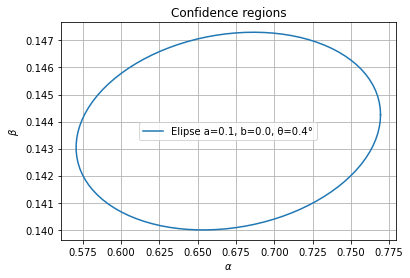

In [495]:
#alpha = h
#beta = wm
A = 2.3
alpha = 2
beta = 3
# A = 6.18 2 sigma
#A = 11.8  3 sigma
a = A * np.sqrt((0.5 *(C[alpha,alpha] + C[beta,beta])) + np.sqrt((0.25*((C[alpha,alpha] - C[beta,beta])**2)) + (C[alpha, beta]**2)))
b = A * np.sqrt((0.5 *(C[alpha,alpha] + C[beta,beta])) - np.sqrt((0.25*((C[alpha,alpha] - C[beta,beta])**2)) + (C[alpha, beta]**2)))
phi = np.radians(0.5 * np.arctan((2* C[alpha, beta]) / (C[alpha,alpha] - C[beta,beta])))

print('phi=', phi)
print('a=', a)
print('b=', b)

plot_ellipse(a, b, phi, center_alpha= h, center_beta= wm)
